In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data Encoding and Scaling
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [3]:
warnings.filterwarnings('ignore')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
df = pd.read_csv('test_data.csv')

In [6]:
df.shape

(6116, 32)

In [7]:
df.drop(['credit_amount',
         'subscription_type_y',
        'org_type'], axis=1, inplace=True)

In [8]:
''' Filled all the null values before encoding the data '''

for col in df.columns:
    if df[col].dtype == np.int64:
        df[col].fillna(0, inplace=True)
    elif df[col].dtype == np.float64:
        df[col].fillna(0.0, inplace=True)
    elif df[col].dtype == object:
        unique_vals = df[col].dropna().unique()
        if set(unique_vals).issubset({'Yes', 'No'}):
            df[col].fillna('No', inplace=True)
        else:
            df[col].fillna('Unknown', inplace=True)

In [9]:
''' This Function is to fill all missing values (if col is int then 0, if col is float then 0.0 and if col is object then 'Unkmown') '''

def fill_missing_values(df):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == np.int64:
            df[col].fillna(0, inplace=True)
        elif df[col].dtype == np.float64:
            df[col].fillna(0.0, inplace=True)
        elif df[col].dtype == object:
            unique_vals = df[col].dropna().unique()
            if set(unique_vals).issubset({'Yes', 'No'}):
                df[col].fillna('No', inplace=True)
            else:
                df[col].fillna('Unknown', inplace=True)
    return df


# Data Encoding

In [11]:
label_col = ['jobma_catcher_industry',]

def label_encoder(df):
    for col in label_col:
        if col in df.columns:
            if df[col].dtype == object or df[col].dtype.name == 'category':
                le_col = LabelEncoder()
                df[col] = le_col.fit_transform(df[col].astype(str))
    return df

In [12]:
def ordinal_encoder(df):
    ordinal_col = ['jobma_catcher_is_deleted', 'company_size', 'plan_type', 'is_unlimited']
    
    is_deleted_order = ['Yes', 'No']
    company_size_order = ['Unknown', '1-25', '26-100', '101-500', '500-1000', 'More than 1000']
    plan_type_order = ['Unknown', 'No', 'Yes']
    is_unlimited_order = ['Unknown', 'No', 'Yes']

    ordinal_order = [is_deleted_order, company_size_order, plan_type_order, is_unlimited_order]

    ordinal = OrdinalEncoder(categories=ordinal_order)
    encoded = ordinal.fit_transform(df[ordinal_col].astype(str))
    encoded_df = pd.DataFrame(encoded, columns=[f'{col}_ord' for col in ordinal_col], index=df.index)

    df.drop(columns=ordinal_col, inplace=True)

    df = pd.concat([df, encoded_df], axis=1)
    
    return df

# Log Transformation

In [14]:
log_cols = [
    'wallet_amount',
    'subscription_amount',
    'number_of_invitations',
    'job_posted',
    'number_of_kits',
    'interview_question',
    'pre_recorded_credit',
    'live_interview_credit'
]

In [15]:
def log_transform(df):
    df = df.copy()
    for col in log_cols:
        if col in df.columns:
            # fill NaNs
            df[col] = df[col].fillna(0)
            # if a number is less than zero, turn it into zero;
            df[col] = df[col].clip(lower=0)
            # safe log1p
            df[col] = np.log1p(df[col])
    return df

# Pipeline

In [17]:
pipeline = Pipeline([
    ('fill_missing_values', FunctionTransformer(fill_missing_values, validate=False)),
    ('label_encoder', FunctionTransformer(label_encoder, validate=False)),
    ('ordinal_encoder', FunctionTransformer(ordinal_encoder, validate=False)),
    ('log_transformation', FunctionTransformer(log_transform, validate=False)), # log transforms the col with outliers
    ('scaler', MinMaxScaler()), # Needs attention to improve model
    # ('pca', PCA(n_components=0.97))
])

In [18]:
''' Visualizing the Pipeline '''
set_config(display='diagram')
pipeline

Pipeline(steps=[('fill_missing_values',
                 FunctionTransformer(func=<function fill_missing_values at 0x000002B95C0493A0>)),
                ('label_encoder',
                 FunctionTransformer(func=<function label_encoder at 0x000002B95C049800>)),
                ('ordinal_encoder',
                 FunctionTransformer(func=<function ordinal_encoder at 0x000002B95C0498A0>)),
                ('log_transformation',
                 FunctionTransformer(func=<function log_transform at 0x000002B95C04AA20>)),
                ('scaler', MinMaxScaler())])

# Data Splitting

In [20]:
X = df

In [21]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [22]:
type(X_train), type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [23]:
len(X_train), len(X_test)

(4892, 1224)

# Fit Pipeline

In [25]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [26]:
type(X_train_transformed), type(X_test_transformed)

(numpy.ndarray, numpy.ndarray)

In [27]:
len(X_train_transformed), len(X_test_transformed)

(4892, 1224)

In [28]:
features_names = df.columns

In [29]:
X_df = pd.DataFrame(X_train_transformed, columns=features_names)
# X'_df = pd.DataFrame(X_train_transformed)

In [30]:
X_df.shape

(4892, 29)

# Convert into Tensor

In [32]:
X_train_tensor = torch.tensor(X_train_transformed, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_transformed, dtype=torch.float32)

In [33]:
type(X_train_tensor), type(X_test_tensor)

(torch.Tensor, torch.Tensor)

# Dataset Class

In [35]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [36]:
train_data = CustomDataset(X_train_tensor)
test_data = CustomDataset(X_test_tensor)

# DataLoader

In [38]:
BATCH_SIZE = 16

In [39]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [40]:
len(train_data), len(test_data)

(4892, 1224)

In [41]:
len(train_dataloader), len(test_dataloader)

(306, 77)

# Define a Model (AutoEncoder in this case)

In [43]:
# class AutoEncoder(nn.Module):
#     def __init__(self, input_shape):
#         super().__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(input_shape, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32)  # bottleneck
#         )

#         self.decoder = nn.Sequential(
#             nn.Linear(32, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, input_shape)
#         )

#     def forward(self, X):
#         encoded = self.encoder(X)
#         decoded = self.decoder(encoded)
#         return encoded, decoded

In [44]:
class DeepAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=128):
        super(DeepAutoencoder, self).__init__()
        
        # Encoder 
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(),                    
            nn.BatchNorm1d(512),               
            nn.Linear(512, 256),               
            nn.LeakyReLU(),                    
            nn.BatchNorm1d(256),                 
            nn.Linear(256, latent_dim),        
        )
        
        # Decoder 
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),        
            nn.LeakyReLU(),                      
            nn.BatchNorm1d(256),               
            nn.Linear(256, 512),               
            nn.LeakyReLU(),                    
            nn.BatchNorm1d(512),               
            nn.Linear(512, input_dim),             
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
        
''' Initializing the model '''
input_dim = X_df.shape[1]
latent_dim = 128
model_1 = DeepAutoencoder(input_dim=input_dim, latent_dim=latent_dim)
model_1.to(device)

DeepAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=29, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=29, bias=True)
    (7): Sigmoid()
  )
)

In [45]:
# ''' Initializing the Model '''

# input_shape = X_df.shape[1]
# model_1 = AutoEncoder(input_shape)
# model_1.to(device)

In [46]:
''' Important Parameters '''
learning_rate = 0.001
epochs = 50

In [47]:
''' Loss Function and Optimizers '''
mse_loss_function = nn.MSELoss()
cosine_loss_function = nn.CosineEmbeddingLoss()

optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=1e-3)

# Training Loop

In [49]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               mse_loss_function:torch.nn.Module,
               cosine_loss_function:torch.nn.Module,
               optimizer:torch.optim.Optimizer
              ):
    model.train()
    epoch_total_loss = 0

    for batch_X in dataloader:
        encoded, decoded = model(batch_X)

        ''' Compute Loss '''
        mse_loss = mse_loss_function(decoded, batch_X)

        batch_size = encoded.shape[0]
        target_labels = torch.ones(batch_size)

        permuted_indices = torch.randperm(batch_size)
        encoded_shuffled = encoded[permuted_indices]

        cosine_loss = cosine_loss_function(encoded, encoded_shuffled, target_labels)
        total_loss = mse_loss + cosine_loss

        ''' BackPropagation '''
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_total_loss = total_loss.item()

    training_loss = epoch_total_loss / len(dataloader)
    return training_loss

# Testing Loop

In [51]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              mse_loss_function:torch.nn.Module,
              cosine_loss_function:torch.nn.Module,
             ):

    epoch_total_loss = 0
    
    model.eval()
    with torch.inference_mode():
        for batch_X in dataloader:
            encoded, decoded = model(batch_X)  # Forward pass

            ''' Compute Loss '''
            mse_loss = mse_loss_function(decoded, batch_X)  # Reconstruction Loss
    
            batch_size = encoded.shape[0]
            target_labels = torch.ones(batch_size)

            # Compare each encoded job to another shuffled job
            permuted_indices = torch.randperm(batch_size)
            encoded_shuffled = encoded[permuted_indices]

            cosine_loss = cosine_loss_function(encoded, encoded_shuffled, target_labels)
            total_loss = mse_loss + cosine_loss
            
            epoch_total_loss += total_loss.item()

        testing_loss = epoch_total_loss / len(dataloader)
        return testing_loss

## Combining Training and Testing Loop into evaluate()

In [53]:
def evaluate(model:torch.nn.Module,
             train_dataloader:torch.utils.data.DataLoader,
             test_dataloader:torch.utils.data.DataLoader,
             mse_loss_function:torch.nn.Module,
             cosine_loss_function:torch.nn.Module,
             epochs:int = 5
            ):
    
    results = {'training_loss':[],
              'testing_loss':[]}

    for epoch in range(epochs):
        training_loss = train_step(model=model,
                                   dataloader=train_dataloader,
                                   mse_loss_function=mse_loss_function,
                                   cosine_loss_function=cosine_loss_function,
                                   optimizer=optimizer
                                  )

        testing_loss = test_step(model=model,
                                   dataloader=test_dataloader,
                                   mse_loss_function=mse_loss_function,
                                   cosine_loss_function=cosine_loss_function
                                  )

        results['training_loss'].append(training_loss)
        results['testing_loss'].append(testing_loss)

        print(f'Epoch {epoch+1}/{epochs} | Training Loss: {training_loss:.5f} | Testing Loss: {testing_loss:.5f}')

    return results

In [54]:
torch.manual_seed(42)

model_1_results = evaluate(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        mse_loss_function=mse_loss_function,
                        cosine_loss_function=cosine_loss_function,
                        epochs=epochs)

Epoch 1/50 | Training Loss: 0.00011 | Testing Loss: 0.02475
Epoch 2/50 | Training Loss: 0.00006 | Testing Loss: 0.02331
Epoch 3/50 | Training Loss: 0.00004 | Testing Loss: 0.04978
Epoch 4/50 | Training Loss: 0.00004 | Testing Loss: 0.03323
Epoch 5/50 | Training Loss: 0.00005 | Testing Loss: 0.02842
Epoch 6/50 | Training Loss: 0.00007 | Testing Loss: 0.02971
Epoch 7/50 | Training Loss: 0.00006 | Testing Loss: 0.02944
Epoch 8/50 | Training Loss: 0.00005 | Testing Loss: 0.03550
Epoch 9/50 | Training Loss: 0.00005 | Testing Loss: 0.01696
Epoch 10/50 | Training Loss: 0.00003 | Testing Loss: 0.03320
Epoch 11/50 | Training Loss: 0.00004 | Testing Loss: 0.01802
Epoch 12/50 | Training Loss: 0.00004 | Testing Loss: 0.01393
Epoch 13/50 | Training Loss: 0.00004 | Testing Loss: 0.01447
Epoch 14/50 | Training Loss: 0.00005 | Testing Loss: 0.01896
Epoch 15/50 | Training Loss: 0.00004 | Testing Loss: 0.01596
Epoch 16/50 | Training Loss: 0.00005 | Testing Loss: 0.02661
Epoch 17/50 | Training Loss: 0.00

# Loss and Accuracy Curves

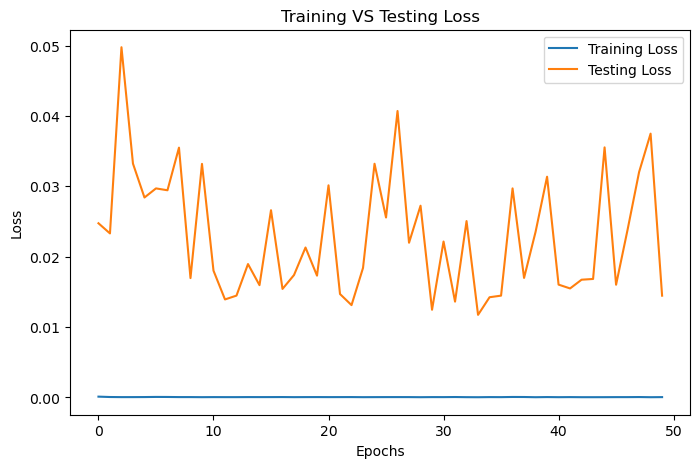

In [56]:
epochs = range(len(model_1_results['training_loss']))

plt.figure(figsize=(8, 5))
plt.plot(epochs, model_1_results['training_loss'], label='Training Loss')
plt.plot(epochs, model_1_results['testing_loss'], label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training VS Testing Loss')
plt.legend()
plt.show()

## Test it on User's Preferences 

In [58]:
X_df.columns

Index(['jobma_catcher_id', 'jobma_catcher_industry', 'jobma_catcher_type',
       'is_premium', 'jobma_catcher_sub_accounts', 'jobma_catcher_is_deleted',
       'jobma_verified', 'subscription_status', 'interview_rate',
       'live_interview_credit', 'pre_recorded_credit', 'credit_value',
       'interview_cost_type', 'subscription_type_x', 'jobma_support_rtc',
       'interview_question', 'video_recording_suppport',
       'sing_up_canditate_after_apply', 'currency', 'company_size',
       'wallet_amount', 'plan_type', 'is_unlimited', 'premium_storage',
       'subscription_amount', 'number_of_subscriptions',
       'number_of_invitations', 'job_posted', 'number_of_kits'],
      dtype='object')

In [59]:
test_df = pd.read_csv('test_data.csv')

In [60]:
user_pref = {'jobma_catcher_id':1111,
             'jobma_catcher_industry':'Unknown',
             'jobma_catcher_type':'1',
             'is_premium':'1',
             'jobma_catcher_sub_accounts':0,
             'jobma_catcher_is_deleted':'No',
             'jobma_verified':1,
             'subscription_status':2,
             'interview_rate':0.,
             'live_interview_credit':11.,
             'pre_recorded_credit':1.00000e+02,
             'credit_value':2,
             'interview_cost_type':1,
             'subscription_type_x':0,
             'jobma_support_rtc':2,
             'interview_question':20,
             'video_recording_suppport':2,
             'sing_up_canditate_after_apply':0,
             'currency':1,
             'company_size':'500-1000',
             'wallet_amount':8.000000e+01,
             'plan_type':'Yes',
             'is_unlimited':'Yes',
             'premium_storage':0.,
             'subscription_amount': 1.13500000e+04,
             'number_of_subscriptions':116.,
             'number_of_invitations':2.0000e+02,
             'job_posted':35.,
             'number_of_kits':39.
            }

In [61]:
original_df = pd.read_csv('recommend1.csv')

In [62]:
original_df = original_df[['jobma_catcher_id', 'jobma_catcher_company']]

In [63]:
def recommend(user_input, model, dataloader, df_original, original_df, pipeline, top_k=5):
    user_df = pd.DataFrame([user_input])
    user_input_transformed = pipeline.transform(user_df)
    user_input_tensor = torch.tensor(user_input_transformed, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        user_embedding, _ = model(user_input_tensor)
        item_embeddings_list = []
        for batch_X in dataloader:
            item_embedding, _ = model(batch_X)
            item_embeddings_list.append(item_embedding)

        item_embeddings = torch.cat(item_embeddings_list, dim=0)

        similarities = F.cosine_similarity(user_embedding, item_embeddings)
        top_indices = similarities.topk(top_k).indices.cpu().numpy()

    recommended = df_original.iloc[top_indices].copy()
    recommended['similarity'] = similarities[top_indices].cpu().numpy()

    merged_df = pd.merge(recommended, original_df[['jobma_catcher_id', 'jobma_catcher_company']], on='jobma_catcher_id', how='left')

    return merged_df[['jobma_catcher_id', 'jobma_catcher_company', 'company_size', 'is_premium', 'wallet_amount', 'similarity']]

In [64]:
result = recommend(user_pref, model_1, test_dataloader, test_df, original_df, pipeline, top_k=5)
print(result.to_string())

   jobma_catcher_id jobma_catcher_company company_size  is_premium  wallet_amount  similarity
0              4179                 JOBMA         1-25         0.0           60.0    0.999971
1              3918                  Test       26-100         0.0           60.0    0.999971
2              2999                   SSI         1-25         0.0           60.0    0.999967
3              4304                   ssi         1-25         1.0           60.0    0.999966
4              3140                   ssi         1-25         0.0            NaN    0.999964


In [65]:
user_pref1 = {'jobma_catcher_id':1111,
             'jobma_catcher_industry':'Unknown',
             'jobma_catcher_type':'1',
             'is_premium':'1',
             'jobma_catcher_sub_accounts':0,
             'jobma_catcher_is_deleted':'No',
             'jobma_verified':1,
             'subscription_status':2,
             'interview_rate':0.,
             'live_interview_credit':11.,
             'pre_recorded_credit':1.00000e+02,
             'credit_value':2,
             'interview_cost_type':1,
             'subscription_type_x':0,
             'jobma_support_rtc':2,
             'interview_question':20,
             'video_recording_suppport':2,
             'sing_up_canditate_after_apply':0,
             'currency':1,
             'company_size':'More than 1000',
             'wallet_amount':8.000000e+01,
             'plan_type':'Yes',
             'is_unlimited':'Yes',
             'premium_storage':0.,
             'subscription_amount': 1.13500000e+04,
             'number_of_subscriptions':116.,
             'number_of_invitations':2.0000e+02,
             'job_posted':35.,
             'number_of_kits':139.
            }

In [66]:
result = recommend(user_pref1, model_1, test_dataloader, test_df, original_df, pipeline, top_k=5)
print(result.to_string())

   jobma_catcher_id jobma_catcher_company company_size  is_premium  wallet_amount  similarity
0              4170                   ssi       26-100         0.0           60.0    0.999962
1              4250                 Jobma      101-500         0.0           60.0    0.999937
2              3902                   ssi       26-100         1.0           60.0    0.999934
3              3731                  Test      101-500         0.0           60.0    0.999931
4              3955                 JOBMA         1-25         0.0           60.0    0.999929
